In [2]:
import numpy as np 
import pandas as pd 

In [ ]:
#Importing Libraries
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

##### <a id="2"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">DATA LOADING & PREPREPROCESSING</p>

For this project, I am using .jpg files of images of portraits. The dataset includes various artists. I am loading data as TensorFlow.Dataset,, with a batch size of 64. I have reduced the image size to (64,64), presuming, it will be computationally less taxing on the GPU.

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">Loading the data</p>

In [ ]:
#Importing data
data_path = "../input/art-portraits/Portraits/"
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 4117 files belonging to 1 classes.


Now that I have the dataset loaded, let us have a look at a few images.

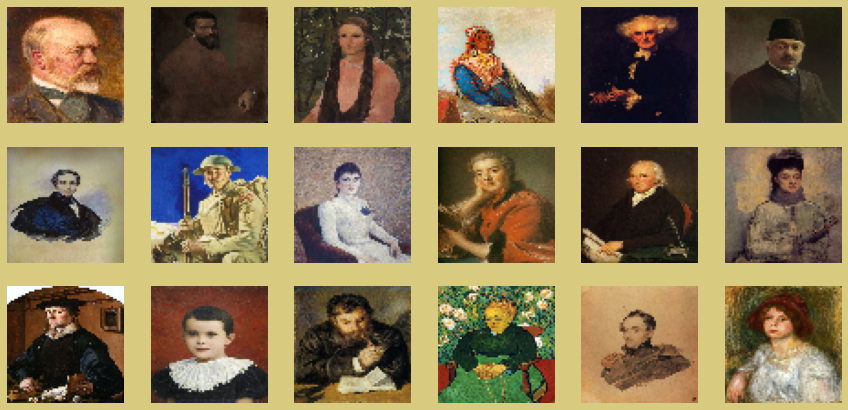

In [ ]:
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset            
Show_Img(data)

Most of the images are portraits. A portrait is a painting representation of a person, The face is predominantly depicted portraits along with expressions and postures. To represent the personality of the subject. Since our model is relative a smaller GAN we have reduced the size of the image. 

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">Preprocessing the data</p>

**Normalization:** For the data normalization, I will convert the data in the range between 0 to 1. This helps in fast convergence and makes it easy for the computer to do calculations faster. 
Each of the three RGB channels in the image can take pixel values ranging from 0 to 256. Dividing it by 255 converts it to a range between 0 to 1. By doing this we 

In [ ]:
#Preprocessing the dataset for model
data = data.map(lambda x: x / 255.0)
data

<MapDataset shapes: (None, 64, 64, 3), types: tf.float32>

In [ ]:
latent_dim = 100
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0

Now that the Generator is framed, let us see what random output our untrained Generator produces to get an idea of the process. 

(-0.5, 63.5, 63.5, -0.5)

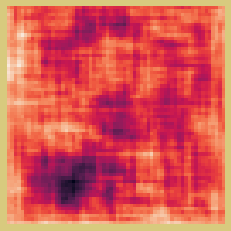

In [ ]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training 
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

Clearly, the output is a random seed containing noise as the Generator is not trained yet. 

<a id="3.2"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">The Discriminator</p>

In GANs the Generator works along with the Discriminator. 

The Discriminator network decided whether the data is fake aka created by the Generator or real i.e. from the original input data. To do so it applies a binary classification method using a sigmoid function to get an output in the range of 0 to 1.

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">Building a Discriminator</p>

In [ ]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 17, 17, 64)       

Now with this discriminator(untrained), let us see what verdict it has for the preiously generated image with random noise. 

In [ ]:
#for the random image generated
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.4992974]], shape=(1, 1), dtype=float32)


In [ ]:
#Code Sourced from keras sample. find the link in the Resorces below

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

<a id="5"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">TRAINING THE MODEL</p>


In [ ]:
#Defining the number of epochs
epochs = 200
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

Epoch 1/200
65/65 [==============================] - 59s 776ms/step - d_loss: 0.6694 - g_loss: 0.7218
Epoch 2/200
65/65 [==============================] - 40s 543ms/step - d_loss: 0.6647 - g_loss: 0.8153
Epoch 3/200
65/65 [==============================] - 40s 538ms/step - d_loss: 0.6517 - g_loss: 0.9289
Epoch 4/200
65/65 [==============================] - 40s 548ms/step - d_loss: 0.6167 - g_loss: 0.9494
Epoch 5/200
65/65 [==============================] - 42s 568ms/step - d_loss: 0.6150 - g_loss: 0.9063
Epoch 6/200
65/65 [==============================] - 39s 531ms/step - d_loss: 0.5958 - g_loss: 0.9531
Epoch 7/200
65/65 [==============================] - 39s 537ms/step - d_loss: 0.6112 - g_loss: 0.9382
Epoch 8/200
65/65 [==============================] - 39s 526ms/step - d_loss: 0.5918 - g_loss: 1.0266
Epoch 9/200
65/65 [==============================] - 39s 540ms/step - d_loss: 0.5917 - g_loss: 1.0093
Epoch 10/200
65/65 [==============================] - 39s 532ms/step - d_loss: 0.5

<a id="6"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">EVALUATING THE MODEL</p>

Now that I have my model trained, let us see how it performs.
Having a look at the performance of the model via Learning Curves

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">Ploting the Learning Curves</p>

Text(0.5, 1.0, 'Learning Curve')

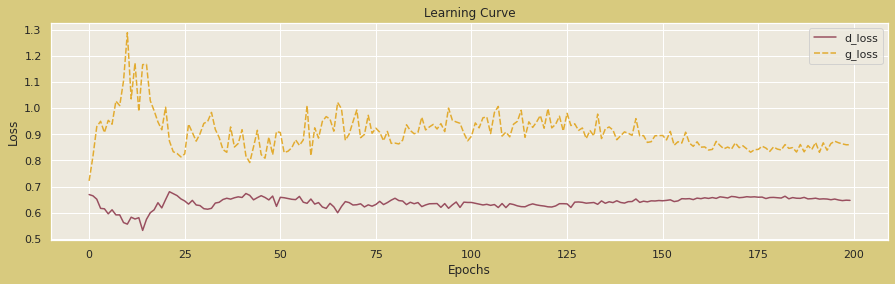

In [ ]:
pal=["#994F5F","#E2AB30"]
#Plotting the learning curve
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df, palette= pal)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")

In [ ]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("Potraits{:02d}.png".format(i)) 
    return 

#Generating images
Images = Potrait_Generator()

Found 18 files belonging to 1 classes.


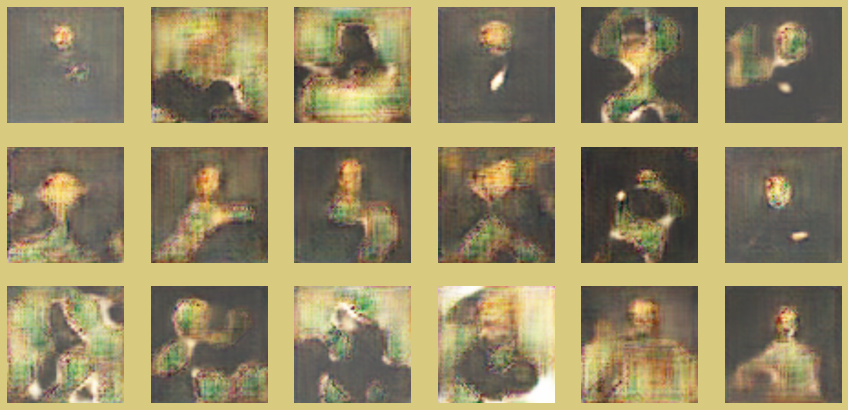

In [ ]:
#Loading generated images
Generated_path = "./"
Potraits_generated = tf.keras.preprocessing.image_dataset_from_directory(Generated_path, label_mode = None)
#Plotting generated images
Show_Img(Potraits_generated)